# 영상 분할

사람의 뇌는 장면을 이해하기 위해 무의식적으로 영상 분할을 수행한다. 컴퓨터 비전의 많은 문제를 해결할 때도 고품질의 영상 분할 작업이 필요하다. 분할이 잘 된다면 영상 검색, 물체 추적, 얼굴 인식, 증강 현실, 동작 인식 등은 반 이상 해결된 셈이다. 하지만 영상 분할은 컴퓨터 비전에서 가장 어려운 문제라고 해도 과언이 아니다. 영상 분할은 컴퓨터 비전이 태동할 때부터 중요한 주제였고 지금도 여전히 핵심 연구 주제이다.

## 이미지 컨투어

컨투어(contour)란 동일한 색 또는 동일한 픽셀값(강도, intensity)을 가지고 있는 영역의 경계선 정보다. 물체의 윤관선, 외형을 파악하는데 사용한다.

도형의 갯수: 3(3)


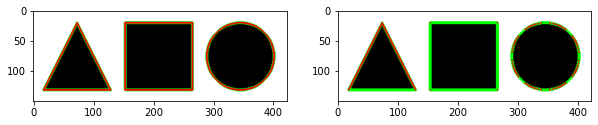

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./img/shapes.png')
img2 = img.copy()

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, imthres = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

contour, hierarchy = cv2.findContours(
    imthres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

contour2, hierarchy = cv2.findContours(
    imthres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print('도형의 갯수: %d(%d)'% (len(contour), len(contour2)))


cv2.drawContours(img, contour, -1, (0,255,0), 4)
cv2.drawContours(img2, contour2, -1, (0,255,0), 4)

for i in contour:
    for j in i:
        cv2.circle(img, tuple(j[0]), 1, (255,0,0), -1) 

for i in contour2:
    for j in i:
        cv2.circle(img2, tuple(j[0]), 1, (255,0,0), -1) 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

3 [[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [-1  1 -1 -1]]]
6 [[[ 2 -1  1 -1]
  [-1 -1 -1  0]
  [ 4  0  3 -1]
  [-1 -1 -1  2]
  [-1  2  5 -1]
  [-1 -1 -1  4]]]


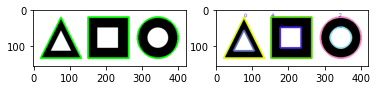

In [10]:
import cv2
import numpy as np

img = cv2.imread('./img/shapes_donut.png')
img2 = img.copy()

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, imthres = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

contour, hierarchy = cv2.findContours(
    imthres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

print(len(contour), hierarchy)
contour2, hierarchy = cv2.findContours(
    imthres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

print(len(contour2), hierarchy)


cv2.drawContours(img, contour, -1, (0,255,0), 3)
for idx, cont in enumerate(contour2): 
    color = [int(i) for i in np.random.randint(0,255, 3)]
    cv2.drawContours(img2, contour2, idx, color, 3)
    cv2.putText(img2, str(idx), tuple(cont[0][0]), cv2.FONT_HERSHEY_PLAIN, \
                                                            1, (0,0,255))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

## 이미지 모멘트와 컨투어 속성

모멘트(moment)는 물리학에서 힘의 양을 기술할 때 사용하는 용어로 영상에서 대상 물체의 양적인 속성을 표현할 때 모멘트를 사용한다. 이미지 모멘트는 컨투어를 이용해서 아래와 같이 공식화한다.

$$
m_{p,q}=\sum_{x}\sum_{y}f(x,y)x^{p}y^{q}
$$

컨투어가 둘러싸는 영역의 $x$, $y$ 좌표의 픽셀 값과 좌표 인덱스의 $p$, $q$ 차수를 곱한 것의 합을 구한다. 각 픽셀의 값은 바이너리 이미지이므로 0이 아닌 모든 값은 1로 계산하고 $p$, $q$의 차수는 0\~3까지로 한다. 예를 들어 $m_{0,0}$은 $f(x,y)x^{0}y^{0}$의 합인데 모든 수의 0차수는 1이므로 컨투어가 감싸는 영역의 1로 표시된 픽셀 개수만큼 1로 곱해서 합산한 것으로 면적을 구하는 것과 같다. $m_{0,1}$, $m_{1,0}$을 $m_{0,0}$으로 나누면 평균 $x$, $y$값을 구할 수 있으며 컨투어 영역의 중심 좌표이다. 0~3차수 모멘트는 공간 모멘트라고 하며 위치나 크기가 달라지면 그 값도 달라진다. 위치가 변해도 값이 동일한 모멘트를 중심 모멘트라고 하며 다음 식과 같다.

$$
\mu_{p,q}=\sum_{x}\sum_{y}f(x,y)(x-\bar{x})^{p}(y-\bar{y})^{q}
$$

$\bar{x}=\frac{m_{10}}{m_{00}}$, $\bar{y}=\frac{m_{01}}{m_{00}}$이다. 중심 모멘트를 정규화하면 크기가 변해도 같은 값을 얻을 수 있다.

$$
n\mu_{p,q}=\frac{\mu_{p,q}}{m_{00}^{\frac{p+q}{2}+1}}
$$

area:9870.00
area:12544.00
area:6216.00


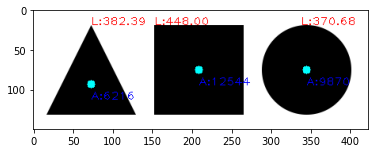

In [12]:
import cv2
import numpy as np

img = cv2.imread('./img/shapes.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, th = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

contours, hierachy = cv2.findContours(
    th, cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE
)

for c in contours:
    mmt = cv2.moments(c)
    # m10/m00, m01/m00  중심점 계산
    cx = int(mmt['m10']/mmt['m00'])
    cy = int(mmt['m01']/mmt['m00'])
    # 영역 넓이
    a = mmt['m00']
    # 영역 외곽선 길이
    l = cv2.arcLength(c, True)
    cv2.circle(img, (cx, cy), 5, (0, 255, 255), -1)
    cv2.putText(img, "A:%.0f"%a, (cx, cy+20) , cv2.FONT_HERSHEY_PLAIN, \
                                                            1, (0,0,255))
    # 컨투어 시작점에 길이 그리기
    cv2.putText(img, "L:%.2f"%l, tuple(c[0][0]), cv2.FONT_HERSHEY_PLAIN, \
                                                            1, (255,0,0))
    # 함수로 컨투어 넓이 계산해서 출력
    print("area:%.2f"%cv2.contourArea(c, False))

plt.imshow(img)
plt.show()

### 컨투어 단순화

실생활에서 얻는 영상은 노이즈와 침식이 일어나는 경우가 많다. 따라서 컨투어도 정확한 컨투어보다 단순화한 컨투어가 쓸모 있는 경우가 많다.

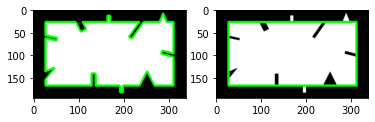

In [21]:
import cv2
import numpy as np

img = cv2.imread('./img/bad_rect.png')
img2 = img.copy()

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
ret, th = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)

contours, hierachy = cv2.findContours(
    th, cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE
)

contour = contours[0]
# 전체 둘레의 0.05로 오차 범위 지정 ---②
epsilon = 0.05 * cv2.arcLength(contour, True)
# 근사 컨투어 계산 ---③
approx = cv2.approxPolyDP(contour, epsilon, True)

# 각각 컨투어 선 그리기 ---④
cv2.drawContours(img, [contour], -1, (0,255,0), 3)
cv2.drawContours(img2, [approx], -1, (0,255,0), 3)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

컨투어를 단순화하는 또 다른 방법은 블록 선체(convex hull)를 만드는 것이다. 블록 선체는 어느 한 부분도 오목하지 않은 상태를 말하는 것으로 대상 객체를 완전히 포함하므로 객체의 외곽 영역을 찾는데 좋다.

False True


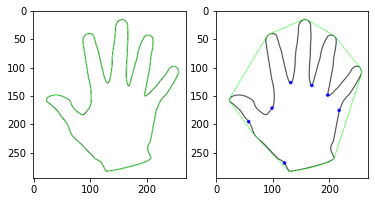

In [24]:
import cv2
import numpy as np

img = cv2.imread('./img/hand.jpg')
img2 = img.copy()
# 그레이 스케일 및 바이너리 스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# 컨투어 찾기와 그리기
contours, heiarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, \
                                         cv2.CHAIN_APPROX_SIMPLE)
cntr = contours[0]
cv2.drawContours(img, [cntr], -1, (0, 255,0), 1)

# 볼록 선체 찾기(좌표 기준)와 그리기
hull = cv2.convexHull(cntr)
cv2.drawContours(img2, [hull], -1, (0,255,0), 1)
# 볼록 선체 만족 여부 확인
print(cv2.isContourConvex(cntr), cv2.isContourConvex(hull))

# 볼록 선체 찾기(인덱스 기준)
hull2 = cv2.convexHull(cntr, returnPoints=False)
# 볼록 선체 결함 찾기 ---⑥
defects = cv2.convexityDefects(cntr, hull2)
# 볼록 선체 결함 순회
for i in range(defects.shape[0]):
    # 시작, 종료, 가장 먼 지점, 거리
    startP, endP, farthestP, distance = defects[i, 0]
    # 가장 먼 지점의 좌표 구하기
    farthest = tuple(cntr[farthestP][0])
    # 거리를 부동 소수점으로 변환
    dist = distance/256.0
    # 거리가 1보다 큰 경우
    if dist > 1 :
        cv2.circle(img2, farthest, 3, (0, 0, 255), -1)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

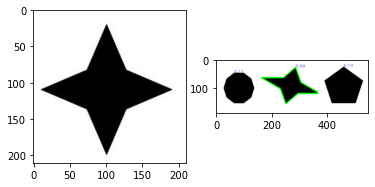

In [25]:
import cv2
import numpy as np


target = cv2.imread('./img/4star.jpg')
shapes = cv2.imread('./img/shapestomatch.jpg')
# 그레이 스케일 변환
targetGray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
shapesGray = cv2.cvtColor(shapes, cv2.COLOR_BGR2GRAY)
# 바이너리 스케일 변환
ret, targetTh = cv2.threshold(targetGray, 127, 255, cv2.THRESH_BINARY_INV)
ret, shapesTh = cv2.threshold(shapesGray, 127, 255, cv2.THRESH_BINARY_INV)
# 컨투어 찾기
cntrs_target, _ = cv2.findContours(
    targetTh, cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE
)
cntrs_shapes, _ = cv2.findContours(
    shapesTh, cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE
)

# 각 도형과 매칭을 위한 반복문
matchs = [] # 컨투어와 매칭 점수를 보관할 리스트
for contr in cntrs_shapes:
    # 대상 도형과 여러 도형 중 하나와 매칭 실행
    match = cv2.matchShapes(cntrs_target[0], contr, cv2.CONTOURS_MATCH_I2, 0.0)
    # 해당 도형의 매칭 점수와 컨투어를 쌍으로 저장
    matchs.append( (match, contr) )
    # 해당 도형의 컨투어 시작지점에 매칭 점수 표시
    cv2.putText(
        shapes, '%.2f'%match, tuple(contr[0][0]),
        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1
    )
# 매칭 점수로 정렬 ---④
matchs.sort(key=lambda x : x[0])
# 가장 적은 매칭 점수를 얻는 도형의 컨투어에 선 그리기 
cv2.drawContours(shapes, [matchs[0][1]], -1, (0,255,0), 3)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(target)
ax2.imshow(shapes)
plt.show()

## 허프 변환

허프 변환(Hough transform)은 영상에서 직선과 원 같은 간단한 모양을 식별한다. 영상은 수많은 픽셀로 구성되는데 수많은 픽셀 속에서 직선 관계를 갖는 픽셀들만 골라내는 것이 허프 선 변환이다. 바이너리 스케일로 경계를 검출한 영상에는 선으로 보여지는 여러 점이 있는데 점마다 여러 개의 가상의 선을 그어서 그 선들 중 평면 원점과 직각을 이루는 선을 찾아 각도와 거리를 계산해 모든 점에게 동일하게 나타나는 선이 있다면 그 점들은 그 선을 따라 직선의 형태라 볼 수 있다. 평면에 3개의 점이 있고 각 점에는 여러 개의 가상의 선이 그려져 있지만 평면의 원점과 직각이 되는 선의 각도$(\theta)$와 길이$(r)$가 세 점 모두에서 같게 나타나는 것은 빨간색 선뿐이다. 경계 검출한 바이너리 스케일 영상을 입력으로 전달하면 $r$, $\theta$를 값으로 갖는 $N \times 1$ 배열을 반환한다.

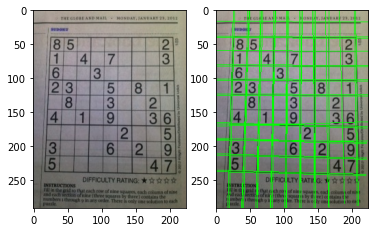

In [33]:
import cv2
import numpy as np

img = cv2.imread('./img/sudoku-01.jpg')
img2 = img.copy()
h, w = img.shape[:2]
# 그레이 스케일 변환 및 엣지 검출 ---①
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(imgray, 100, 200 )
# 허프 선 검출 ---②
lines = cv2.HoughLines(edges, 1, np.pi/180, 130)
for line in lines: # 검출된 모든 선 순회
    r,theta = line[0] # 거리와 각도wh
    tx, ty = np.cos(theta), np.sin(theta) # x, y축에 대한 삼각비
    x0, y0 = tx*r, ty*r  #x, y 기준(절편) 좌표
    # 직선 방정식으로 그리기 위한 시작점, 끝점 계산
    x1, y1 = int(x0 + w*(-ty)), int(y0 + h * tx)
    x2, y2 = int(x0 - w*(-ty)), int(y0 - h * tx)
    # 선그리기
    cv2.line(img2, (x1, y1), (x2, y2), (0,255,0), 1)

#결과 출력    
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

vertices: 10
vertices: 16
vertices: 3
vertices: 4
vertices: 4


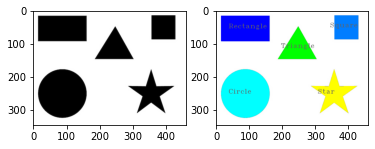

In [37]:
import cv2
import numpy as np

# 이미지를 읽어서 그레이 스케일 및 스레시홀드 변환
img = cv2.imread('./img/5shapes.jpg')
img2 = img.copy()
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

# 컨투어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, \
                                        cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # 각 컨투어에 근사 컨투어로 단순화 
    approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
    # 꼭지점의 갯수
    vertices = len(approx)
    print("vertices:", vertices)
    
    # 중심점 찾기
    mmt = cv2.moments(contour)
    cx,cy = int(mmt['m10']/mmt['m00']), int(mmt['m01']/mmt['m00'])
    
    name = "Unkown"
    if vertices == 3: # 꼭지점이 3개는 삼각형
        name = "Triangle"
        color = (0,255,0)
    elif vertices == 4: # 꼭지점 4개는 사각형
        x,y,w,h = cv2.boundingRect(contour)
        if abs(w-h) <= 3:   # 폭과 높이의 차이가 3보다 작으면 정사각형
            name = 'Square'
            color = (0,125,255)
        else:               # 폭과 높이 차이가 3보다 크면 직사각형
            name = 'Rectangle'
            color = (0,0,255)
    elif vertices == 10:  # 꼭 지점 갯수 10개는 별 
        name = 'Star'
        color = (255,255,0)
    elif vertices >= 15: # 꼭 지점 10개 이상이면 원
        name = 'Circle'
        color = (0,255,255)
    # 컨투어 그리기    
    cv2.drawContours(img2, [contour], -1, color, -1)
    # 도형 이름 출력
    cv2.putText(img2, name, (cx-50, cy), cv2.FONT_HERSHEY_COMPLEX_SMALL,\
                                                         1, (100,100,100), 1)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

```python
import cv2
import numpy as np


img = cv2.imread('../img/coins_connected.jpg')
rows, cols = img.shape[:2]
cv2.imshow('original', img)

# 동전 표면을 흐릿하게 피라미드평균시프트 적용
mean = cv2.pyrMeanShiftFiltering(img, 20, 50)
cv2.imshow('mean', mean)
# 바이너리 이미지 변환
gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3,3), 0)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imshow('thresh', thresh)
# 거리 변환
dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 3)
# 거리 값을 0 ~255로 변환
dst = (dst / (dst.max() - dst.min()) * 255).astype(np.uint8)
cv2.imshow('dst', dst)

# 거리 변환결과에서 로칼 최대 값 구하기
## 팽창 적용(동전 크기 정도의 구조화 요소 필요),
localMx = cv2.dilate(dst, np.ones((50,50), np.uint8))
## 로칼 최대 값 저장 할 배열 생성
lm = np.zeros((rows, cols), np.uint8)
## 팽창 적용전 이미지와 같은 픽셀이 로컬 최대 값이므로 255로 설정
lm[(localMx==dst) & (dst != 0)] = 255
cv2.imshow('localMx', lm)

# 로컬 최대값으로 색 채우기
## 로컬 최대 값이 있는 좌표 구하기
seeds = np.where(lm ==255)
seed = np.stack( (seeds[1], seeds[0]), axis=-1)
## 색 채우기를 위한 채우기 마스크 생성
fill_mask = np.zeros((rows+2, cols+2), np.uint8)
for x,y in seed:
    ## 로칼 최대값을 시드로해서 평균 시프트 영상에 색채우기 
    ret = cv2.floodFill(
        mean, fill_mask, (x,y), (255,255,255), 
        (10,10,10), (10,10,10)
    )
cv2.imshow('floodFill', mean)

# 색 채우기 적용한 영상에 다시 거리 변환 적용
gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
dst = ((dst / (dst.max() - dst.min())) * 255).astype(np.uint8)
cv2.imshow('dst2', dst)

# 거리 변환 결과값의 절반 이상을 차지한 영역은 확실한 전경으로 설정
ret, sure_fg = cv2.threshold(dst, 0.5*dst.max(), 255,0)
cv2.imshow('sure_fg', sure_fg)

# 거리 변환 결과를 반전해서 확실한 배경 찾기
_, bg_th = cv2.threshold(dst, 0.3*dst.max(),  255, cv2.THRESH_BINARY_INV)
bg_dst = cv2.distanceTransform(bg_th, cv2.DIST_L2, 5)
bg_dst = ((bg_dst / (bg_dst.max() - bg_dst.min())) * 255).astype(np.uint8)
ret, sure_bg = cv2.threshold(bg_dst, 0.3*bg_dst.max(), 255,cv2.THRESH_BINARY)
cv2.imshow('sure_bg', sure_bg)


# 불확실한 영역 설정 : 확실한 배경을 반전해서 확실한 전경을 빼기
ret, inv_sure_bg = cv2.threshold(sure_bg, 127, 255,cv2.THRESH_BINARY_INV)
unkown = cv2.subtract(inv_sure_bg, sure_fg)
cv2.imshow('unkown', unkown)

# 연결된 요소 레이블링
_, markers = cv2.connectedComponents(sure_fg)

# 레이블링을 1씩 증가 시키고 0번 레이블 알 수 없는 영역을 0번 레이블로 설정
markers = markers+1
markers[unkown ==255] = 0
print("워터쉐드 전:", np.unique(markers))
colors = []
marker_show = np.zeros_like(img)
for mid in np.unique(markers): # 선택한 마커 아이디 갯수 만큼 반복
    color = [int(j) for j in np.random.randint(0,255, 3)]
    colors.append((mid, color))
    marker_show[markers==mid] = color
    coords = np.where(markers==mid)
    x, y = coords[1][0], coords[0][0]
    cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, \
                                                             2, (255,255,255))
cv2.imshow('before', marker_show)

# 레이블링이 완성된 마커로 워터 쉐드 적용
markers = cv2.watershed(img, markers)
print("워터쉐드 후:", np.unique(markers))

for mid, color in colors: # 선택한 마커 아이디 갯수 만큼 반복
    marker_show[markers==mid] = color
    coords = np.where(markers==mid)
    if coords[0].size <= 0 : 
        continue
    x, y = coords[1][0], coords[0][0]
    cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, \
                                                             2, (255,255,255))
marker_show[markers==-1] = (0,255,0)
cv2.imshow('watershed marker', marker_show)

img[markers==-1] = (0,255,0)
cv2.imshow('watershed', img)

# 동전 추출을 위한 마스킹 생성
mask = np.zeros((rows, cols), np.uint8)
# 배경 마스크 생성
mask[markers!=1] = 255
# 배경 지우기
nobg = cv2.bitwise_and(img, img, mask=mask)
# 동전만 있는 라벨 생성 (배경(1), 경계(-1) 없는)
coin_label = [l for l in np.unique(markers) if (l != 1 and l !=-1)]
# 동전 라벨 순회 하면서 동전 영역만 추출
for i, label in enumerate(coin_label):
    mask[:,:] = 0
    # 해당 동전 추출 마스크 생성
    mask[markers ==label] = 255
    # 동전 영역만 마스크로 추출
    coins = cv2.bitwise_and(img, img, mask=mask)
    # 동전 하나만 있는 곳에서 최외곽 컨투어 추출
    contour, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )
    # 동전을 감싸는 사각형 좌표
    x,y,w,h = cv2.boundingRect(contour[0])
    # 동전 영역만 추출해서 출력
    coin = coins[y:y+h, x:x+w]
    cv2.imshow('coin%d'%(i+1), coin)
    cv2.imwrite('../img/coin_test/coin%d.jpg'%(i+1), coin)

cv2.waitKey()
cv2.destroyAllWindows()
```

## 지역 근접 그래프

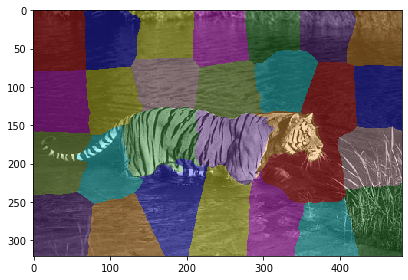

In [19]:
from skimage import io, segmentation
from skimage import color

tiger = io.imread('./img/tiger.jpg')
seg = segmentation.slic(
    tiger, n_segments=30, compactness=40.0,
    enforce_connectivity=True, sigma=3, start_label=1
)
io.imshow(color.label2rgb(seg, tiger, bg_label=0))
plt.show()

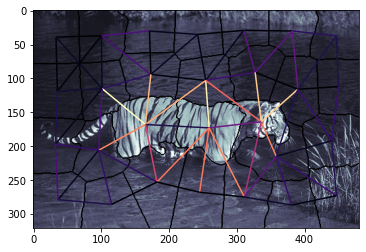

In [8]:
from skimage.future import graph

g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger)

In [32]:
import networkx as nx

def build_rag(labels, image):
    g = nx.Graph()
    nrows, ncols = labels.shape
    print(g.node)
    for row in range(nrows):
        for col in range(ncols):
            current_label = labels[row, col]
            if not current_label in g:
                g.add_node(current_label)
                g[current_label]['total color'] = np.zeros(3, dtype=np.float)
                g[current_label]['pixel count'] = 0
            if row < nrows - 1 and labels[row + 1, col] != current_label:
                g.add_edge(current_label, labels[row + 1, col])
            if col < ncols - 1 and labels[row, col + 1] != current_label:
                g.add_edge(current_label, labels[row, col + 1])
            g[current_label]['total color'] += image[row, col]
            g[current_label]['pixel count'] += 1
    return g

In [33]:
import networkx as nx

def build_rag_3d(labels, image):
    g = nx.Graph()
    nplns, nrows, ncols = labels.shape
    for pln in range(nplns):
        for row in range(nrows):
            for col in range(ncols):
                current_label = labels[pln, row, col]
                if not current_label in g:
                    g.add_node(current_label)
                    g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                    g.node[current_label]['pixel count'] = 0
                if pln < nplns - 1 and labels[pln + 1, row, col] != current_label:
                    g.add_edge(current_label, labels[pln + 1, row, col])
                if row < nrows - 1 and labels[pln, row + 1, col] != current_label:
                    g.add_edge(current_label, labels[pln, row + 1, col])
                if col < ncols - 1 and labels[pln, row, col + 1] != current_label:
                    g.add_edge(current_label, labels[pln, row, col + 1])
                g[current_label]['total color'] += image[pln, row, col]
                g[current_label]['pixel count'] += 1
    return g

In [43]:
import networkx as nx
import numpy as np
from scipy import ndimage 

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # 반환값은 사용되지 않지만, generic_filter() 함수에서 필요하다.
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    print(dir(g))
    footprint = ndimage.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndimage.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    for n in g:
        g._node[n]['total color'] = np.zeros(3, np.double)
        g._node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g._node[n]['total color'] += image[index]
        g._node[n]['pixel count'] += 1
    return g

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adj', '_node', 'add_edge', 'add_edges_from', 'add_node', 'add_nodes_from', 'add_weighted_edges_from', 'adj', 'adjacency', 'adjlist_inner_dict_factory', 'adjlist_outer_dict_factory', 'clear', 'clear_edges', 'copy', 'degree', 'edge_attr_dict_factory', 'edge_subgraph', 'edges', 'get_edge_data', 'graph', 'graph_attr_dict_factory', 'has_edge', 'has_node', 'is_directed', 'is_multigraph', 'name', 'nbunch_iter', 'neighbors', 'node_attr_dict_factory', 'node_dict_factory', 'nodes', 'number_of_edges', 'number_of_nodes', 'order', 'remove_edge', 'remove_edges_from', 'remove_node', 'remove_nodes_from', 'si

C:\Users\ryu\anaconda3\envs\vision\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


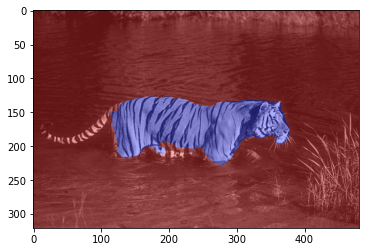

In [46]:
import numpy as np
import matplotlib.pyplot as plt

g = build_rag(seg, tiger)
for n in g:
    node = g._node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g._node[u]['mean'] - g._node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)


def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

threshold_graph(g, 80)

map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger))

In [ ]:
import cv2
import numpy as np

# 이미지 읽기
img = cv2.imread('../img/coins_connected.jpg')
rows, cols = img.shape[:2]
cv2.imshow('original', img)


# 동전 표면을 흐릿하게 피라미드평균시프트 적용
mean = cv2.pyrMeanShiftFiltering(img, 20, 50)
cv2.imshow('mean', mean)
# 바이너리 이미지 변환
gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3,3), 0)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imshow('thresh', thresh)
# 거리 변환
dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 3)
# 거리 값을 0 ~255로 변환
dst = ( dst / (dst.max() - dst.min()) * 255 ).astype(np.uint8)
cv2.imshow('dst', dst)

# 거리 변환결과에서 로칼 최대 값 구하기
## 팽창 적용(동전 크기 정도의 구조화 요소 필요),
localMx = cv2.dilate(dst, np.ones((50,50), np.uint8))
## 로칼 최대 값 저장 할 배열 생성
lm = np.zeros((rows, cols), np.uint8)
## 팽창 적용전 이미지와 같은 픽셀이 로컬 최대 값이므로 255로 설정
lm[(localMx==dst) & (dst != 0)] = 255
cv2.imshow('localMx', lm)

# 로컬 최대값으로 색 채우기
## 로컬 최대 값이 있는 좌표 구하기
seeds = np.where(lm ==255)
seed = np.stack( (seeds[1], seeds[0]), axis=-1)
## 색 채우기를 위한 채우기 마스크 생성
fill_mask = np.zeros((rows+2, cols+2), np.uint8)
for x,y in seed:
    ## 로칼 최대값을 시드로해서 평균 시프트 영상에 색채우기 
    ret = cv2.floodFill(mean, fill_mask, (x,y), (255,255,255), \
                                            (10,10,10), (10,10,10))
cv2.imshow('floodFill', mean)

# 색 채우기 적용한 영상에 다시 거리 변환 적용
gray = cv2.cvtColor(mean, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
dst = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
dst = ( (dst / (dst.max() - dst.min())) * 255 ).astype(np.uint8)
cv2.imshow('dst2', dst)

# 거리 변환 결과값의 절반 이상을 차지한 영역은 확실한 전경으로 설정
ret, sure_fg = cv2.threshold(dst, 0.5*dst.max(), 255,0)
cv2.imshow('sure_fg', sure_fg)

# 거리 변환 결과를 반전해서 확실한 배경 찾기
_, bg_th = cv2.threshold(dst, 0.3*dst.max(),  255, cv2.THRESH_BINARY_INV)
bg_dst = cv2.distanceTransform(bg_th, cv2.DIST_L2, 5)
bg_dst = ( (bg_dst / (bg_dst.max() - bg_dst.min())) * 255 ).astype(np.uint8)
ret, sure_bg = cv2.threshold(bg_dst, 0.3*bg_dst.max(), 255,cv2.THRESH_BINARY)
cv2.imshow('sure_bg', sure_bg)


# 불확실한 영역 설정 : 확실한 배경을 반전해서 확실한 전경을 빼기
ret, inv_sure_bg = cv2.threshold(sure_bg, 127, 255,cv2.THRESH_BINARY_INV)
unkown = cv2.subtract(inv_sure_bg, sure_fg)
cv2.imshow('unkown', unkown)

# 연결된 요소 레이블링
_, markers = cv2.connectedComponents(sure_fg)

# 레이블링을 1씩 증가 시키고 0번 레이블 알 수 없는 영역을 0번 레이블로 설정
markers = markers+1
markers[unkown ==255] = 0
print("워터쉐드 전:", np.unique(markers))
colors = []
marker_show = np.zeros_like(img)
for mid in np.unique(markers): # 선택한 마커 아이디 갯수 만큼 반복
    color = [int(j) for j in np.random.randint(0,255, 3)]
    colors.append((mid, color))
    marker_show[markers==mid] = color
    coords = np.where(markers==mid)
    x, y = coords[1][0], coords[0][0]
    cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, \
                                                             2, (255,255,255))
cv2.imshow('before', marker_show)

# 레이블링이 완성된 마커로 워터 쉐드 적용
markers = cv2.watershed(img, markers)
print("워터쉐드 후:", np.unique(markers))

for mid, color in colors: # 선택한 마커 아이디 갯수 만큼 반복
    marker_show[markers==mid] = color
    coords = np.where(markers==mid)
    if coords[0].size <= 0 : 
        continue
    x, y = coords[1][0], coords[0][0]
    cv2.putText(marker_show, str(mid), (x+20, y+20), cv2.FONT_HERSHEY_PLAIN, \
                                                             2, (255,255,255))
marker_show[markers==-1] = (0,255,0)
cv2.imshow('watershed marker', marker_show)

img[markers==-1] = (0,255,0)
cv2.imshow('watershed', img)

# 동전 추출을 위한 마스킹 생성
mask = np.zeros((rows, cols), np.uint8)
# 배경 마스크 생성
mask[markers!=1] = 255
# 배경 지우기
nobg = cv2.bitwise_and(img, img, mask=mask)
# 동전만 있는 라벨 생성 (배경(1), 경계(-1) 없는)
coin_label = [l for l in np.unique(markers) if (l != 1 and l !=-1)]
# 동전 라벨 순회 하면서 동전 영역만 추출
for i, label in enumerate(coin_label):
    mask[:,:] = 0
    # 해당 동전 추출 마스크 생성
    mask[markers ==label] = 255
    # 동전 영역만 마스크로 추출
    coins = cv2.bitwise_and(img, img, mask=mask)
    # 동전 하나만 있는 곳에서 최외곽 컨투어 추출
    _, contour, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,\
                                         cv2.CHAIN_APPROX_NONE)
    # 동전을 감싸는 사각형 좌표
    x,y,w,h = cv2.boundingRect(contour[0])
    # 동전 영역만 추출해서 출력
    coin = coins[y:y+h, x:x+w]
    cv2.imshow('coin%d'%(i+1), coin)
    cv2.imwrite('../img/coin_test/coin%d.jpg'%(i+1), coin)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

win_name = 'scan'
# 이미지 읽기
img = cv2.imread("../img/paper.jpg")
cv2.imshow('original', img)
cv2.waitKey(0)
draw = img.copy()

# 그레이스 스케일 변환 및 케니 엣지
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0) # 가우시안 블러로 노이즈 제거
edged = cv2.Canny(gray, 75, 200)    # 케니 엣지로 경계 검출
cv2.imshow(win_name, edged)
cv2.waitKey(0)

# 컨투어 찾기
(_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, \
                                                cv2.CHAIN_APPROX_SIMPLE)
# 모든 컨투어 그리기
cv2.drawContours(draw, cnts, -1, (0,255,0))
cv2.imshow(win_name, draw)
cv2.waitKey(0)

# 컨투어들 중에 영역 크기 순으로 정렬
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
for c in cnts:
    # 영역이 가장 큰 컨투어 부터 근사 컨투어 단순화
    peri = cv2.arcLength(c, True)   # 둘레 길이
    # 둘레 길이의 0.02 근사값으로 근사화
    vertices = cv2.approxPolyDP(c, 0.02 * peri, True) 
    if len(vertices) == 4: # 근사한 꼭지점이 4개면 중지
        break
pts = vertices.reshape(4, 2) # N x 1 x 2 배열을 4 x 2크기로 조정
for x,y in pts:
    cv2.circle(draw, (x,y), 10, (0,255,0), -1) # 좌표에 초록색 동그라미 표시
cv2.imshow(win_name, draw)
cv2.waitKey(0)
merged = np.hstack((img, draw))

#### 이하 [예제 5-8]과 동일 ####
# 좌표 4개 중 상하좌우 찾기 ---② 
sm = pts.sum(axis=1)                 # 4쌍의 좌표 각각 x+y 계산
diff = np.diff(pts, axis = 1)       # 4쌍의 좌표 각각 x-y 계산

topLeft = pts[np.argmin(sm)]         # x+y가 가장 값이 좌상단 좌표
bottomRight = pts[np.argmax(sm)]     # x+y가 가장 큰 값이 좌상단 좌표
topRight = pts[np.argmin(diff)]     # x-y가 가장 작은 것이 우상단 좌표
bottomLeft = pts[np.argmax(diff)]   # x-y가 가장 큰 값이 좌하단 좌표

# 변환 전 4개 좌표 
pts1 = np.float32([topLeft, topRight, bottomRight , bottomLeft])

# 변환 후 영상에 사용할 서류의 폭과 높이 계산 ---③ 
w1 = abs(bottomRight[0] - bottomLeft[0])    # 상단 좌우 좌표간의 거리
w2 = abs(topRight[0] - topLeft[0])          # 하당 좌우 좌표간의 거리
h1 = abs(topRight[1] - bottomRight[1])      # 우측 상하 좌표간의 거리
h2 = abs(topLeft[1] - bottomLeft[1])        # 좌측 상하 좌표간의 거리
width = max([w1, w2])                       # 두 좌우 거리간의 최대값이 서류의 폭
height = max([h1, h2])                      # 두 상하 거리간의 최대값이 서류의 높이

# 변환 후 4개 좌표
pts2 = np.float32([[0,0], [width-1,0], 
                    [width-1,height-1], [0,height-1]])

# 변환 행렬 계산 
mtrx = cv2.getPerspectiveTransform(pts1, pts2)
# 원근 변환 적용
result = cv2.warpPerspective(img, mtrx, (width, height))
cv2.imshow(win_name, result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import colorsys
import time
import cv2
import os
import random
import matplotlib.pylab as plt

print(cv2.__version__)
# 4.1.0

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return 256*np.array(colors)


model_path = 'models\\'
conf = 0.5
thresh = 0.3

# load the COCO class labels our Mask R-CNN was trained on
labels_path = os.path.sep.join([model_path, "object_detection_classes_coco.txt"])
labels = open(labels_path).read().strip().split("\n")

# derive the paths to the Mask R-CNN weights and model configuration
weights_path = os.path.sep.join([model_path, "frozen_inference_graph.pb"])
config_path = os.path.sep.join([model_path, "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

print(weights_path, config_path)

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weights_path, config_path)

image = cv2.imread('images/pets.png')
original = image.copy()

blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
(boxes, masks) = net.forward(["detection_out_final",  "detection_masks"])

num_classes = masks.shape[1]
num_detections = boxes.shape[2]
print('# instances: {}'.format(num_detections))
colors = random_colors(num_detections)
print("# classes: {}".format(num_classes))


h = image.shape[0]
w = image.shape[1]

for i in range(num_detections):
    
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    
    if score > conf:
        
        class_id = int(box[1])
        print(class_id, score)

        left = int(w * box[3])
        top = int(h * box[4])
        right = int(w * box[5])
        bottom = int(h * box[6])

        left = max(0, min(left, w - 1))
        top = max(0, min(top, h - 1))
        right = max(0, min(right, w - 1))
        bottom = max(0, min(bottom, h - 1))

        # Extract the mask for the object
        class_mask = mask[class_id]

        # colorize and show the mask on the image
        label = labels[class_id]
    
        # Resize the mask, threshold, color and apply it on the image
        class_mask = cv2.resize(class_mask, (right - left + 1, bottom - top + 1))
        mask = (class_mask > thresh)
        roi = image[top:bottom+1, left:right+1][mask]

        color_index = np.random.randint(0, len(colors)-1)
        color = np.array(colors[color_index])

        image[top:bottom+1, left:right+1][mask] = (0.4*color + 0.6 * roi).astype(np.uint8)

        # Draw the contours on the image
        mask = mask.astype(np.uint8)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image[top:bottom+1, left:right+1], contours, -1, color, 3, cv2.LINE_8, hierarchy, 100)
        
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        top = max(top, label_size[1])
        cv2.putText(image, label, ((left + right)//2, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)


cv2.imwrite('images/instance_seg_out.png', image)

In [ ]:
# http://dl.caffe.berkeleyvision.org/fcn8s-heavy-pascal.caffemodel
import matplotlib.pylab as plt
import numpy as np
import imutils
import time
import cv2
print(cv2.__version__)

# load the class label names
lines = open('models/pascal-classes.txt').read().strip().split("\n")
classes, colors = [], []
for line in lines:
    words = line.split(' ')
    classes.append(words[0])
    colors.append(list(map(int, words[1:]))) 
colors = np.array(colors, dtype="uint8")
#print(classes)

# initialize the legend visualization
legend = np.zeros(((len(classes) * 25) + 25, 300, 3), dtype="uint8")

# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(classes, colors)):
     # draw the class name + color on the legend
     color = [int(c) for c in color]
     cv2.putText(legend, className, (5, (i * 25) + 17), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
     cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25), tuple(color), -1)

# load our serialized model from disk
print("[INFO] loading model...")
model = cv2.dnn.readNetFromCaffe('models/fcn8s-heavy-pascal.prototxt',
                                 'models/fcn8s-heavy-pascal.caffemodel')

# load the input image, resize it, and construct a blob from it,
# but keeping mind mind that the original input image dimensions
start = time.time()
image = cv2.imread('images/cycling.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=500)

# perform a forward pass using the segmentation model
blob = cv2.dnn.blobFromImage(image, 1, (image.shape[1],image.shape[0]))
model.setInput(blob)
output = model.forward()
end = time.time()

# show the amount of time inference took
print("[INFO] inference took {:.4f} seconds".format(end - start))

# infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(num_classes, height, width) = output.shape[1:4]

# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
labels = output[0].argmax(0)

# given the class ID map, we can map each of the class IDs to its
# corresponding color
mask = colors[labels]

# resize the mask and class map such that its dimensions match the
# original size of the input image (we're not using the class map
# here for anything else but this is how you would resize it just in
# case you wanted to extract specific pixels/classes)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
labels = cv2.resize(labels, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# perform a weighted combination of the input image with the mask to
# form an output visualization
output = ((0.4 * image) + (0.6 * mask)).astype("uint8")
legend = imutils.resize(legend,  height=output.shape[0])

plt.figure(figsize=(20,30))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('Original Image', size=30)
plt.subplot(222), plt.imshow(mask), plt.axis('off'), plt.title('Segmentation map', size=30)
plt.subplot(223), plt.imshow(output), plt.axis('off'), plt.title('Image with Segmentaion overlay', size=30)
plt.subplot(224), plt.imshow(legend), plt.axis('off'), plt.title('legends', size=30)
plt.show()

In [ ]:
# https://www.isro.gov.in/pslv-c25-mars-orbiter-mission/pictures-mars-colour-camera-mcc-onboard-india%E2%80%99s-mars-orbiter
# https://www.isro.gov.in/image-galleries
# RandomWalk Segmentation with scikit-image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.segmentation import random_walker
from skimage import img_as_float
from skimage.exposure import rescale_intensity
from skimage.io import imread
from skimage.color import rgb2gray

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

img = imread('images/earth_by_MCC.png')
#img = rgb2gray(img)
mask = imread('images/earth_by_MCC_mask.png')
markers = np.zeros(img.shape[:2],np.uint8)
markers[(mask[...,0] >= 200)&(mask[...,1] <= 20)&(mask[...,2] <= 20)] = 1
markers[(mask[...,0] <= 20)&(mask[...,1] >= 200)&(mask[...,2] <= 20)] = 2
#print(np.unique(markers))

# Run random walker algorithm
labels = random_walker(img, markers, beta=9, mode='bf', multichannel=True)
#print(np.unique(labels))
labels2 = random_walker(img, markers, beta=9, mode='bf', multichannel=True, return_full_prob = True)
#print(labels2.shape)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 18), sharex=True, sharey=False)
fig.subplots_adjust(0,0,1,0.975,0.01,0.05)
ax1.imshow(mask, interpolation='nearest'), ax1.axis('off')
ax1.set_title('Original Image with Markers', size=25)
ax2.imshow(img, interpolation='nearest'), ax2.contour(labels, linewidths=5, colors='r'), ax2.axis('off')
ax2.set_title('Segmentation Contour', size=25)
ax3.imshow(labels, cmap='gray', interpolation='nearest'), ax3.axis('off')
ax3.set_title('Segmentation', size=25)
prob = ax4.imshow(labels2[1,...], cmap='inferno', interpolation='nearest')
ax4.axis('off'), ax4.set_title('Segmentation Probabilities', size=25)
colorbar(prob)
#fig.colorbar(prob, ax=ax4, orientation="horizontal", pad=0.01)
plt.show()

In [ ]:
img = imread('images/CT_bones.png')
#img = rgb2gray(img)
mask = imread('images/CT_bones_mask.png')
markers = np.zeros(img.shape[:2],np.uint8)
markers[(mask[...,0] == 255)&(mask[...,1] == 0)&(mask[...,2] == 0)] = 3
markers[(mask[...,0] == 0)&(mask[...,1] == 255)&(mask[...,2] == 0)] = 2
markers[(mask[...,0] == 0)&(mask[...,1] == 0)&(mask[...,2] == 255)] = 1
#print(np.unique(markers))

# Run random walker algorithm
labels = random_walker(img, markers, beta=9, mode='bf', multichannel=True)
#print(np.unique(labels))
labels2 = random_walker(img, markers, beta=9, mode='bf', multichannel=True, return_full_prob = True)
#print(labels2.shape)
# Plot results
from skimage.color import gray2rgb
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 20), sharex=True, sharey=False)
fig.subplots_adjust(0,0,1,0.975,0.01,0.05)
ax1.imshow(img, interpolation='nearest'), ax1.axis('off')
ax1.set_title('Original Image', size=25)
ax2.imshow(mask, interpolation='nearest'), ax2.axis('off')
ax2.set_title('Original Image with Markers', size=25)
ax3.imshow(img, interpolation='nearest'), ax3.contour(labels, linewidths=5, colors='r'), ax3.axis('off')
ax3.set_title('Segmentation Contour', size=25)
labels = gray2rgb(labels) #labels[...,np.newaxis]
labels[labels[...,0]==1] = [128,128,255]
labels[labels[...,0]==2] = [128,255,128]
labels[labels[...,0]==3] = [255,128,128]
ax4.imshow((0.6*labels + 0.4*img).astype(np.uint8), cmap='jet', interpolation='nearest'), ax4.axis('off')
ax4.set_title('Segmentation', size=25)
prob = ax5.imshow(labels2[2,...], cmap='jet', interpolation='nearest')
ax5.axis('off'), ax5.set_title('Segmentation Probabilities', size=25)
colorbar(prob)
prob = ax6.imshow(labels2[1,...], cmap='jet', interpolation='nearest')
ax6.axis('off'), ax6.set_title('Segmentation Probabilities', size=25)
colorbar(prob)
#fig.colorbar(prob, ax=ax4, orientation="horizontal", pad=0.01)
plt.show()